In [80]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn import linear_model as lm
import sklearn.preprocessing as pre
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.utils import shuffle
from sklearn import svm

from sklearn.svm import SVC

from IPython.display import display, Latex, Markdown

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('mrc_table5.csv')

In [3]:
pd.set_option('display.max_columns', None)
#data['k_q1_m'] + data['k_q2_m'] + data['k_q3_m'] + data['k_q4_m'] + data['k_q5_m']

### Idea: predict child most likely quintile given data

In [4]:
data.columns

Index(['super_opeid', 'cohort', 'name', 'type', 'tier', 'tier_name', 'iclevel',
       'region', 'state', 'cz',
       ...
       'kq1_cond_parq5_age20', 'kq2_cond_parq5_age20', 'kq3_cond_parq5_age20',
       'kq4_cond_parq5_age20', 'kq5_cond_parq5_age20',
       'ktop1pc_cond_parq1_age20', 'ktop1pc_cond_parq2_age20',
       'ktop1pc_cond_parq3_age20', 'ktop1pc_cond_parq4_age20',
       'ktop1pc_cond_parq5_age20'],
      dtype='object', length=207)

In [5]:
columns = ['cohort', 'name', 'type', 'tier', 'tier_name', 'iclevel',
       'region', 'state', 'county', 'count_m', 'par_mean_m', 'par_rank_m', \
          'par_q1_m', 'par_q2_m', 'par_q3_m', 'par_q4_m', 'par_q5_m', 'par_top10pc_m', 'par_top5pc_m', \
          'par_top1pc_m', 'par_toppt1pc_m', 'k_q1_m', 'k_q2_m', 'k_q3_m', 'k_q4_m', 'k_q5_m']
data_1 = data[columns]
# it seems that age20 , f and m dont exist in the dataset

In [6]:
data_1 = data_1.dropna()

In [7]:
# set a column ml_q with the most likely quintile
qs = []
for i, row in data_1.iterrows():
    quantile = np.argmax(data_1[['k_q1_m', 'k_q2_m', 'k_q3_m', 'k_q4_m', 'k_q5_m']].loc[i].values) + 1
    qs.append(quantile)

In [68]:
data_2 = data_1.copy()
data_2['label'] = qs

In [69]:
data_2 = data_2.drop(['k_q1_m', 'k_q2_m', 'k_q3_m', 'k_q4_m', 'k_q5_m', 'tier_name'], 1)

In [70]:
data_2 = data_2.reset_index()
data_2 = data_2.drop('index',1)

In [71]:
# dummies
data_2 = pd.get_dummies(data_2)

### Data Exploration

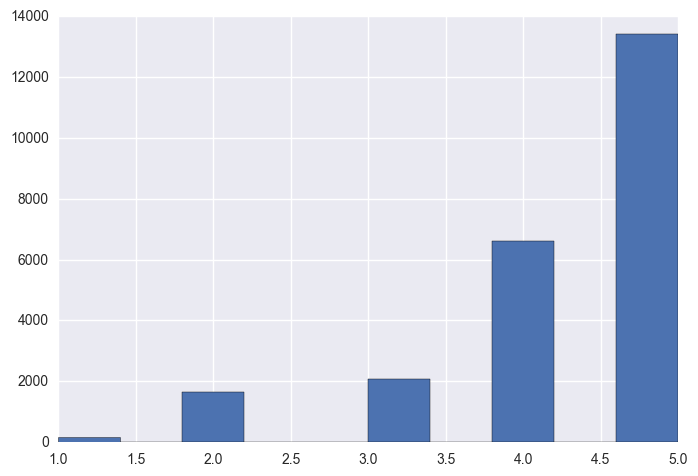

In [12]:
data_2['label'].hist()
plt.show()

In [13]:
# heatmap
correlations = data_2.corr()
#label_corrs = (correlations[abs(correlations['label']) > 0.4][['label']]
#                     .sort_values('label', ascending=False))

#correlations_reduced = data_2[label_corrs.index].corr()
#f, ax = plt.subplots(figsize=(10, 7))
#sns.heatmap(correlations_reduced, annot=True, vmax=.8, square=True)
#plt.title('Heat Map for features correlated with SalesPrice')
#sales_price_corrs

In [15]:
label_corrs = (correlations[abs(correlations['label']) > 0.4][['label']]
                     .sort_values('label', ascending=False))

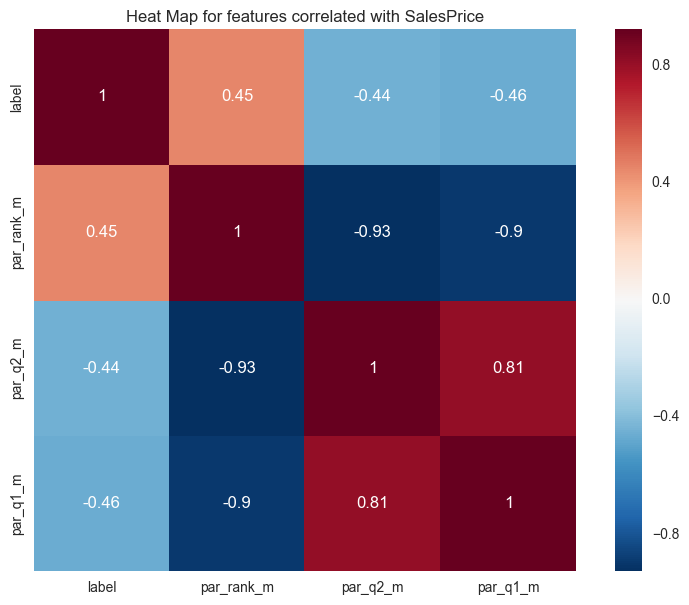

In [16]:
# Interesting: only parent rank has a large correlation with the label!
correlations_reduced = data_2[label_corrs.index].corr()
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(correlations_reduced, annot=True, vmax=.8, square=True)
plt.title('Heat Map for features correlated with SalesPrice')

### Model

In [72]:
y_label = data_2.pop('label')
features = data_2.copy()

In [73]:
features.shape

(23877, 3208)

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1600)
pca.fit(features)
features = pca.transform(features)

In [75]:
#shuffle data
train_features, train_labels = shuffle(features, y_label, random_state = 200)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(train_features,\
                                train_labels, test_size=0.2, random_state=200)

In [77]:
x_train.shape

(19101, 1600)

In [81]:
# model
model_1 = Pipeline([ 
    ('enet', svm.LinearSVC(C=0.774263682681, penalty = 'l1', dual= False))
])

model_2 = Pipeline([ 
    ('svm', svm.SVC(C=10.0, kernel='linear'))
])


In [82]:
model_1.fit(x_train, y_train)

Pipeline(steps=[('enet', LinearSVC(C=0.774263682681, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0))])

In [83]:
pred = model_1.predict(x_test)

In [84]:
from sklearn.metrics import accuracy_score

In [85]:
print(accuracy_score(y_test, pred))

0.70540201005


Trying  100  features
Trying  400  features
Trying  700  features
Trying  1000  features
Trying  1300  features
Trying  1600  features
Trying  1900  features
Trying  2200  features
Trying  2500  features
Trying  2800  features


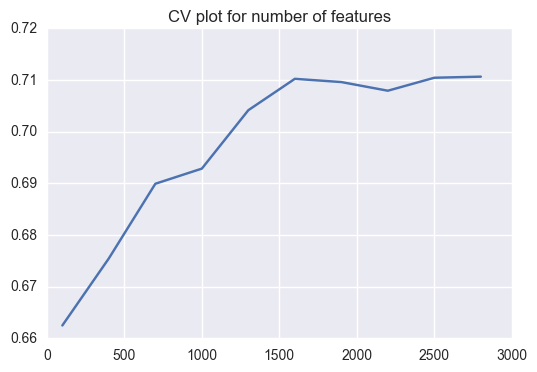

In [59]:
# how many features should we grab?
num = np.arange(100,3000,300)
score = []
for n in num:
    pca = PCA(n_components = n)
    pca.fit(features)
    f = pca.transform(features)
    train_features, train_labels = shuffle(f, y_label, random_state = 200)
    x_train, x_test, y_train, y_test = train_test_split(train_features,\
                                train_labels, test_size=0.2, random_state=200)
    model_1.fit(x_train, y_train)
    pred = model_1.predict(x_test)
    score.append(accuracy_score(y_test, pred))
    print('Trying ', n, ' features')
plt.title('CV plot for number of features')
plt.plot(num, score)
plt.show()

In [33]:
# cross validation

# How is SVM doing?


# Code for plot
margins = np.logspace(-9,1, 10)
score = []
for a in margins:
    svc = svm.LinearSVC(C=a, penalty = 'l1', dual= False).fit(x_train, y_train)
    scores = cross_val_score(svc, x_test, y_test, cv=5)
    score.append(np.mean(scores))


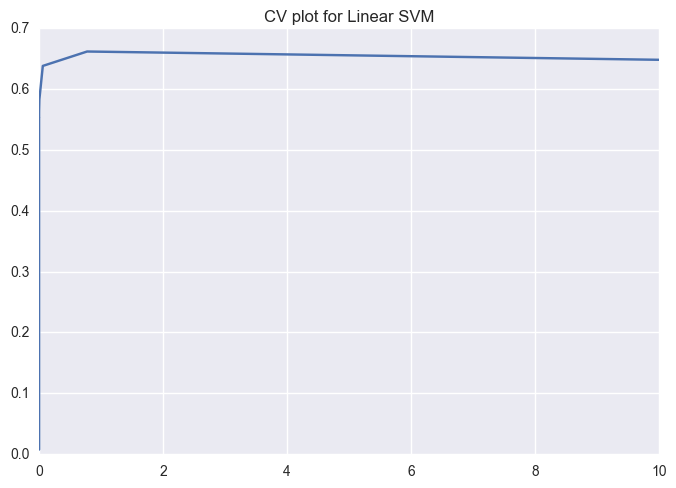

Best Alpha:  0.774263682681  Best score:  0.661433751231


In [36]:
plt.title('CV plot for Linear SVM')
plt.plot(margins, score)
plt.show()

print('Best Alpha: ', margins[np.argmax(score)], ' Best score: ', np.max(score))

In [87]:
from sklearn.ensemble import AdaBoostClassifier
sv = svm.LinearSVC(C=0.774263682681, penalty = 'l1', dual= False).fit(x_train, y_train)
Ada = AdaBoostClassifier(base_estimator=sv, algorithm='SAMME', n_estimators=5, learning_rate=0.001, random_state=None)

In [88]:
Ada.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=LinearSVC(C=0.774263682681, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0),
          learning_rate=0.001, n_estimators=5, random_state=None)

In [ ]:
pred = Ada.predict(x_test)
print(accuracy_score(y_test, pred))